In [1]:
import os
import wget
import tarfile
import numpy as np
import string
from tools import *

In [2]:
proteins = ('Hst5', 'Sic1', 'Tau', 'TIA1')
sizes = (10000, 15000, 30000, 10000)

In [3]:
# Download ensembles from Zenodo
url = 'https://zenodo.org/record/4817583/files/ENSEMBLES.tar?download=1'
filename = wget.download(url)

# Release tarbomb
my_tar = tarfile.open('ENSEMBLES.tar')
my_tar.extractall('.')
my_tar.close()

for p in proteins:
    if p == 'TIA1':
        my_tar = tarfile.open('TIA1.tar')
        my_tar.extractall('.')
        my_tar.close()
        os.rename('Backmapping', 'TIA1_ENSEMBLE')
    else:
        my_tar = tarfile.open(p+'.tar')
        my_tar.extractall('.')
        my_tar.close()
        os.rename('pulchraed', p+'_ENSEMBLE')
        
my_tar = tarfile.open('WEIGHTS.tar')
my_tar.extractall('.')
my_tar.close()

In [ ]:
# Download and untar weights
wurl = {
    'Hst5' = 'https://zenodo.org/record/4817583/files/Hst5_WEIGHTS.tar?download=1',
    'Sic1' = 'https://zenodo.org/record/4817583/files/Sic1_WEIGHTS.tar?download=1',
    'Tau' = 'https://zenodo.org/record/4817583/files/Tau_WEIGHTS.tar?download=1',
    'TIA1' = 'https://zenodo.org/record/4817583/files/TIA1_WEIGHTS.tar?download=1'
}

for p in proteins:
    filename = wget.download(wurl[p])
    my_tar = tarfile.open(p+'_WEIGHTS.tar')
    my_tar.extractall('.')
    my_tar.close()

In [3]:
exps = {
    'Hst5': np.loadtxt('../SAXS_data/saxs_hst5_323k.dat'),
    'Sic1': np.loadtxt('../SAXS_data/saxs_sic1.dat'),
    'Tau': np.loadtxt('../SAXS_data/saxs_tau.dat'),
    'TIA1': np.loadtxt('../SAXS_data/saxs_tia1.dat')
}
# To make q units coherent
exps['Sic1'][...,0] = exps['Sic1'][...,0]*10
exps['TIA1'][...,0] = exps['TIA1'][...,0]*10

grids = {}
for p in proteins:
    grids[p] = np.loadtxt('GRID_'+p)
    #calculate \gamma
    g = np.log(grids[p][...,4]/grids[p][...,5])
    g = g.reshape(len(g),1)
    grids[p] = np.append(grids[p], g, axis=1)

/storage1/francesco/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


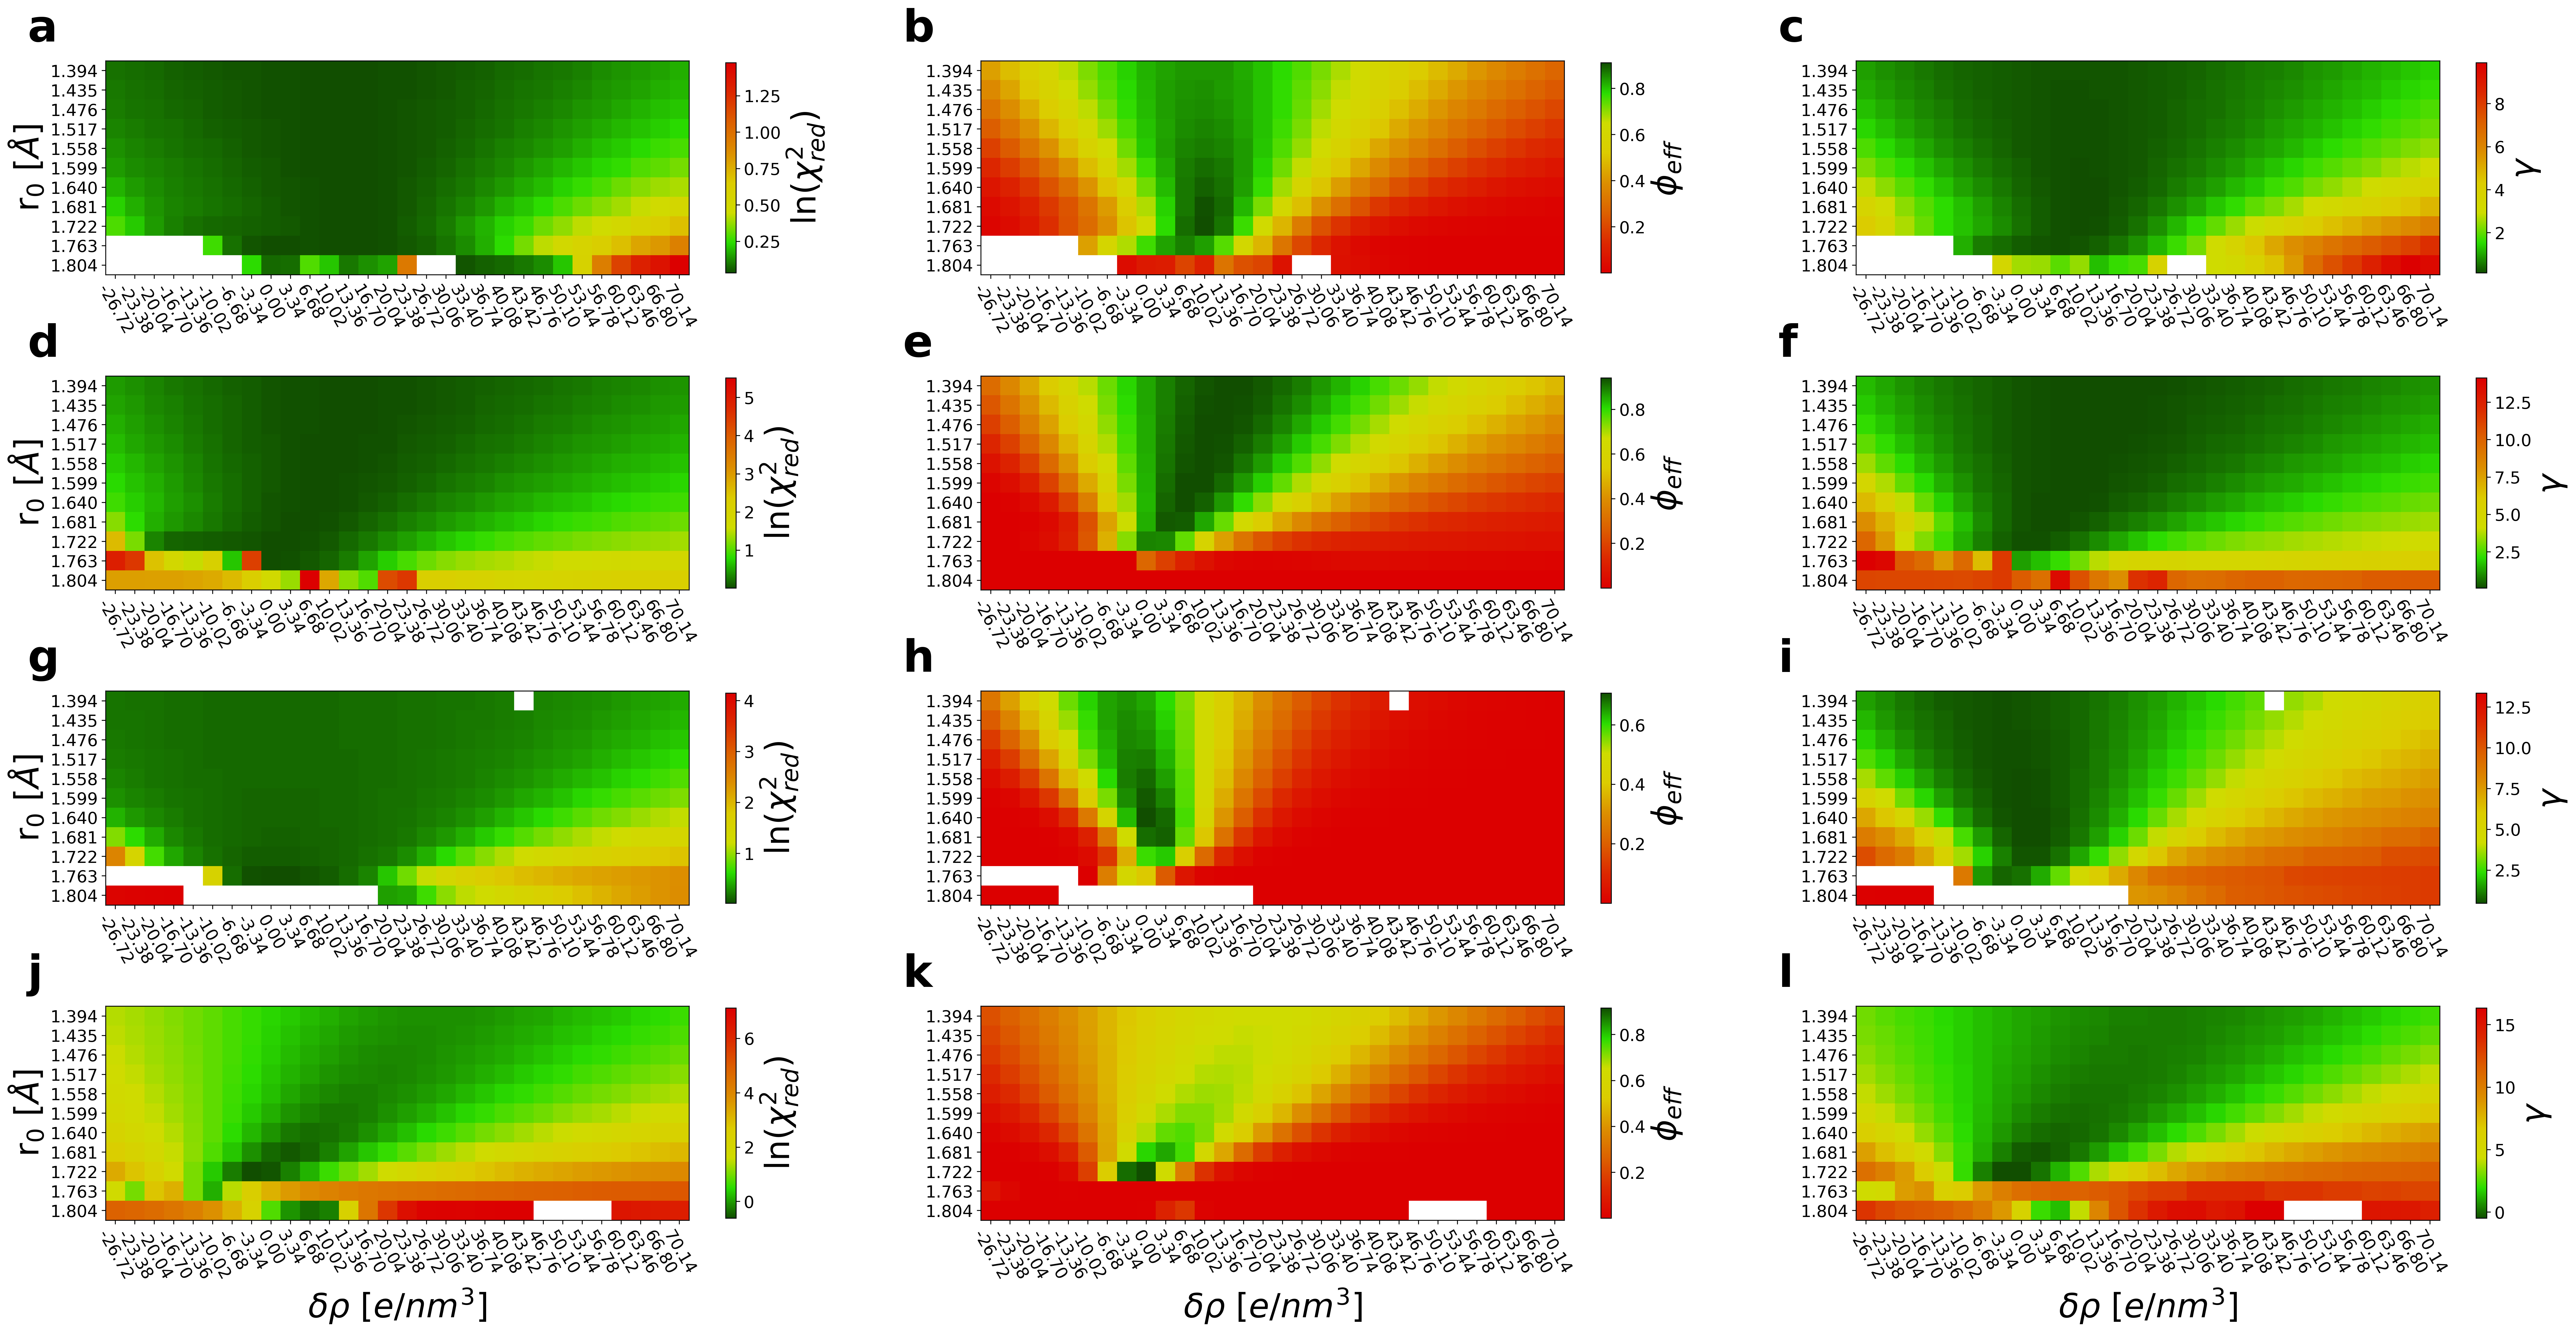

In [264]:
# Plotting grids
mpl.rcParams['font.size'] = 15
fig, axs = plt.subplots(nrows=4,ncols=3, figsize=(40,20), facecolor='w', dpi=300)
for i,p in enumerate(grids.keys()):
    im = axs[i,0].imshow(np.log(grids[p][...,4]).reshape(len(dro),len(r0)).T, cmap=rtg)
    plt.colorbar(im, ax=axs[i,0],shrink=0.80).set_label(r'$\ln(\chi^2_{red})$', fontsize=30)
    
    im = axs[i,1].imshow(grids[p][...,5].reshape(len(dro),len(r0)).T, cmap=rtg_r)
    plt.colorbar(im, ax=axs[i,1],shrink=0.80).set_label(r'$\phi_{eff}$', fontsize=30)
    
    im = axs[i,2].imshow(grids[p][...,6].reshape(len(dro),len(r0)).T, cmap=rtg)
    plt.colorbar(im, ax=axs[i,2],shrink=0.80).set_label(r'$\gamma$', fontsize=30)

c=0
for i in range(4):
    axs[i,0].set_ylabel(r'r$_0$ $[\AA]$', fontsize=30)
    for j in range(3):
        axs[i,j].text(-4.5,-1.5, string.ascii_lowercase[c], fontsize=40, weight='bold')
        axs[i,j].set_yticks(np.arange(len(r0)))
        axs[i,j].set_yticklabels(('%.3f'%(x) for x in r0))
        axs[i,j].set_xticks(np.arange(len(dro)))
        axs[i,j].set_xticklabels(('%.2f'%(x) for x in dro), Rotation=300)
        axs[3,j].set_xlabel(r'$\delta\rho$ $[e/nm^3]$', fontsize=30)
        c+=1

plt.savefig('allgrids.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

In [14]:
# Finding \gamma minima
mins = {}
for k,v in grids.items():
    mins[k] = minfind(v)
    print(mins[k][0])
    print('Best ensemble '+k)
    print('dro: '+str(mins[k][1]))
    print('r0: '+str(mins[k][2]))
    print('chi2: '+str(v[...,4][mins[k][0]]))
    print('phi_eff: '+str(v[...,5][mins[k][0]]))
    print('\n')

129
Best ensemble Hst5
dro: 10.02
r0: 1.722
chi2: 1.0361
phi_eff: 0.911


125
Best ensemble Sic1
dro: 10.02
r0: 1.5579999999999998
chi2: 1.0236
phi_eff: 0.9405


94
Best ensemble Tau
dro: 0.0
r0: 1.64
chi2: 1.1363
phi_eff: 0.7072


85
Best ensemble TIA1
dro: -3.34
r0: 1.722
chi2: 0.5398
phi_eff: 0.8841




In [4]:
# Finding the global minimum

# Normalize \gamma
s = 0
for k,v in grids.items():
    #min to 0
    shift = np.nanmin(v[...,6])
    tmp = v[...,6] - shift
    
    #rescale 0-1
    scale = np.nanmax(v[...,6])
    tmp /= scale
    
    s += tmp
s = s/len(proteins)
gmin = np.nanargmin(s)

print( 'Global minimum dro: %.3f'%(grids['Hst5'][gmin][1]*3.34) )
print( 'Global minimum r0: %.3f'%(grids['Hst5'][gmin][2]*1.64) )

Global minimum dro: 3.340
Global minimum r0: 1.681


In [11]:
klds = {}
for k,v in grids.items():
    klds[k] = grid_kld(v, k+'_WEIGHTS/', mins[k][0])

/storage1/francesco/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


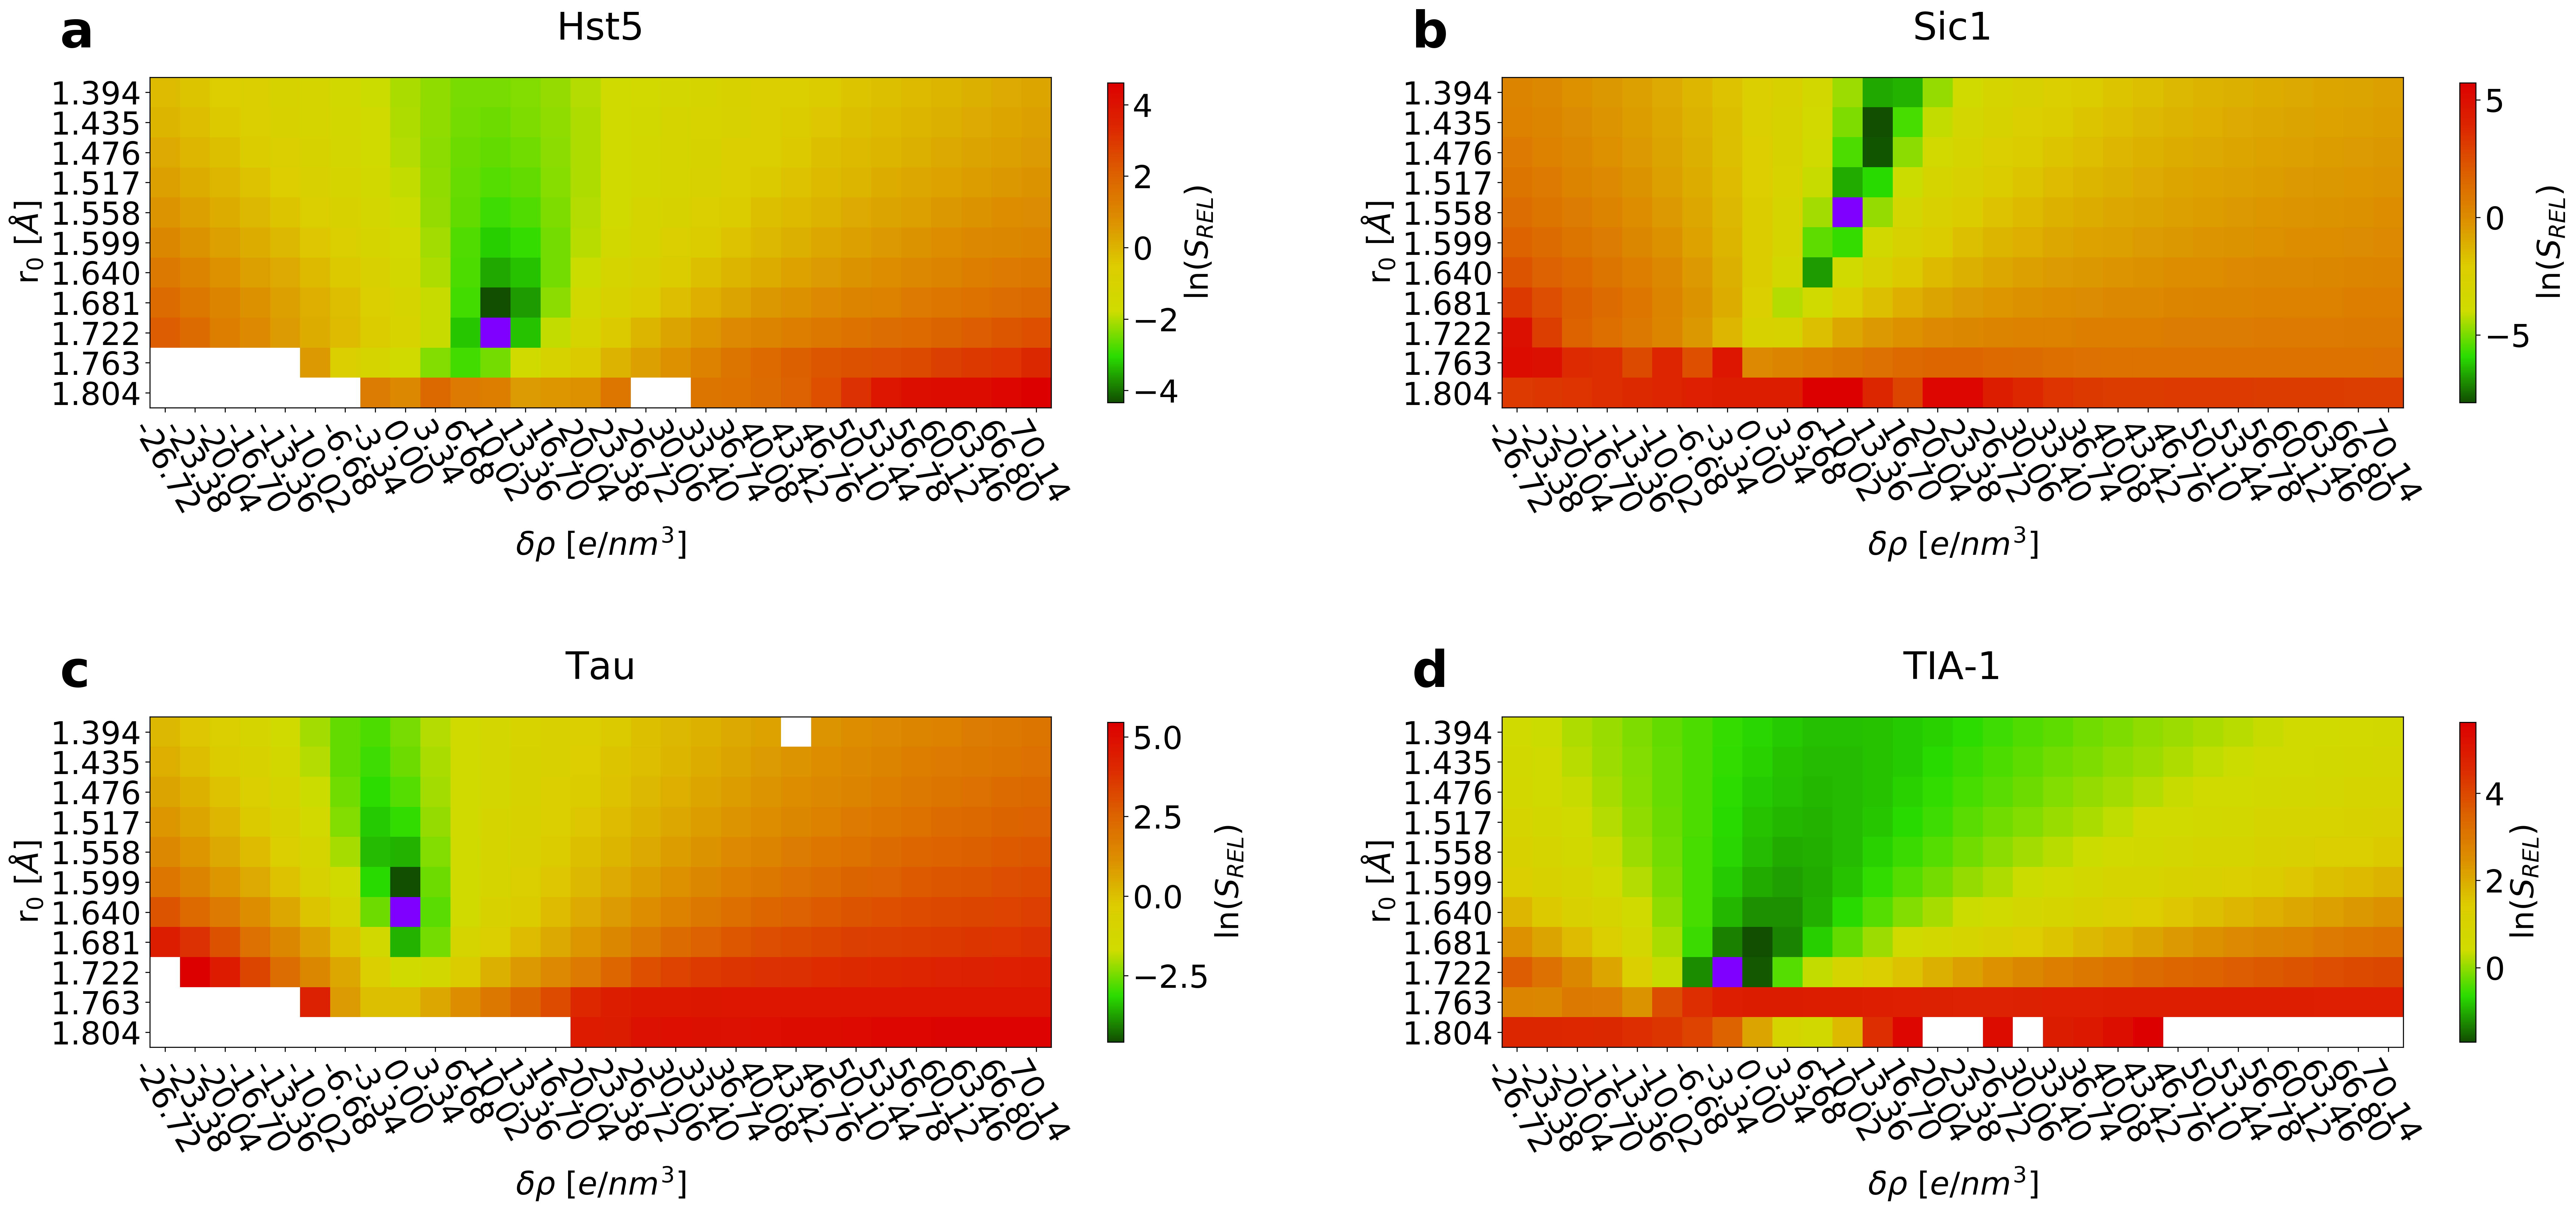

In [301]:
# Plotting relative entropies on the grid
mpl.rcParams['font.size'] = 19
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(35,17), facecolor='w', dpi=300)
c=0
for i in range(2):
    for j in range(2):
        p = tuple(grids.keys())[c]
        axs[i,j].set_title(p,pad=30, fontsize=30)
        im = axs[i,j].imshow(np.log(klds[p]).reshape(len(dro),len(r0)).T, cmap=rtg)
        axs[i,j].set_yticks(np.arange(len(r0)))
        axs[i,j].set_yticklabels(('%.3f'%(x) for x in r0))
        axs[i,j].set_xticks(np.arange(len(dro)))
        axs[i,j].set_xticklabels(('%.2f'%(x) for x in dro), Rotation=300)
        axs[i,j].set_xlabel(r'$\delta\rho$ $[e/nm^3]$', fontsize=25)
        axs[i,j].set_ylabel(r'r$_0$ $[\AA]$', fontsize=25)
        axs[i,j].text(-3.5,-1.5, string.ascii_lowercase[c], fontsize=40, weight='bold')
        plt.colorbar(im, ax=axs[i,j],shrink=0.60).set_label(r'$\ln(S_{REL})$', fontsize=25)
        
        mask = np.full(np.shape(klds[p]),np.inf)
        mask[mins[p][0]] = 100
        axs[i,j].imshow(mask.reshape(len(dro),len(r0)).T, cmap=plt.cm.rainbow)
        
        c += 1
plt.savefig('kld.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

In [120]:
# Calculate Rg for each conformer
rg = {}
for i,p in enumerate(proteins):
    rg[p] = rg_calc(p+'_ENSEMBLE',sizes[i])

In [26]:
# Calculate average Rg, weighted for each point of the grid
rg_avs = {}
for k,v in grids.items():
    rg_avs[k] = []
    wdir = p_+'WEIGHTS/'
    for i in v:
        gind = str(int(i[0]))
        if i[3] != np.inf:
            w = np.loadtxt(wdir+'w'+gind+'.dat')[...,1]
            rg_avs[k].append( np.average(rg[k], weights=w) )
        else:
            rg_avs[k].append(np.inf)

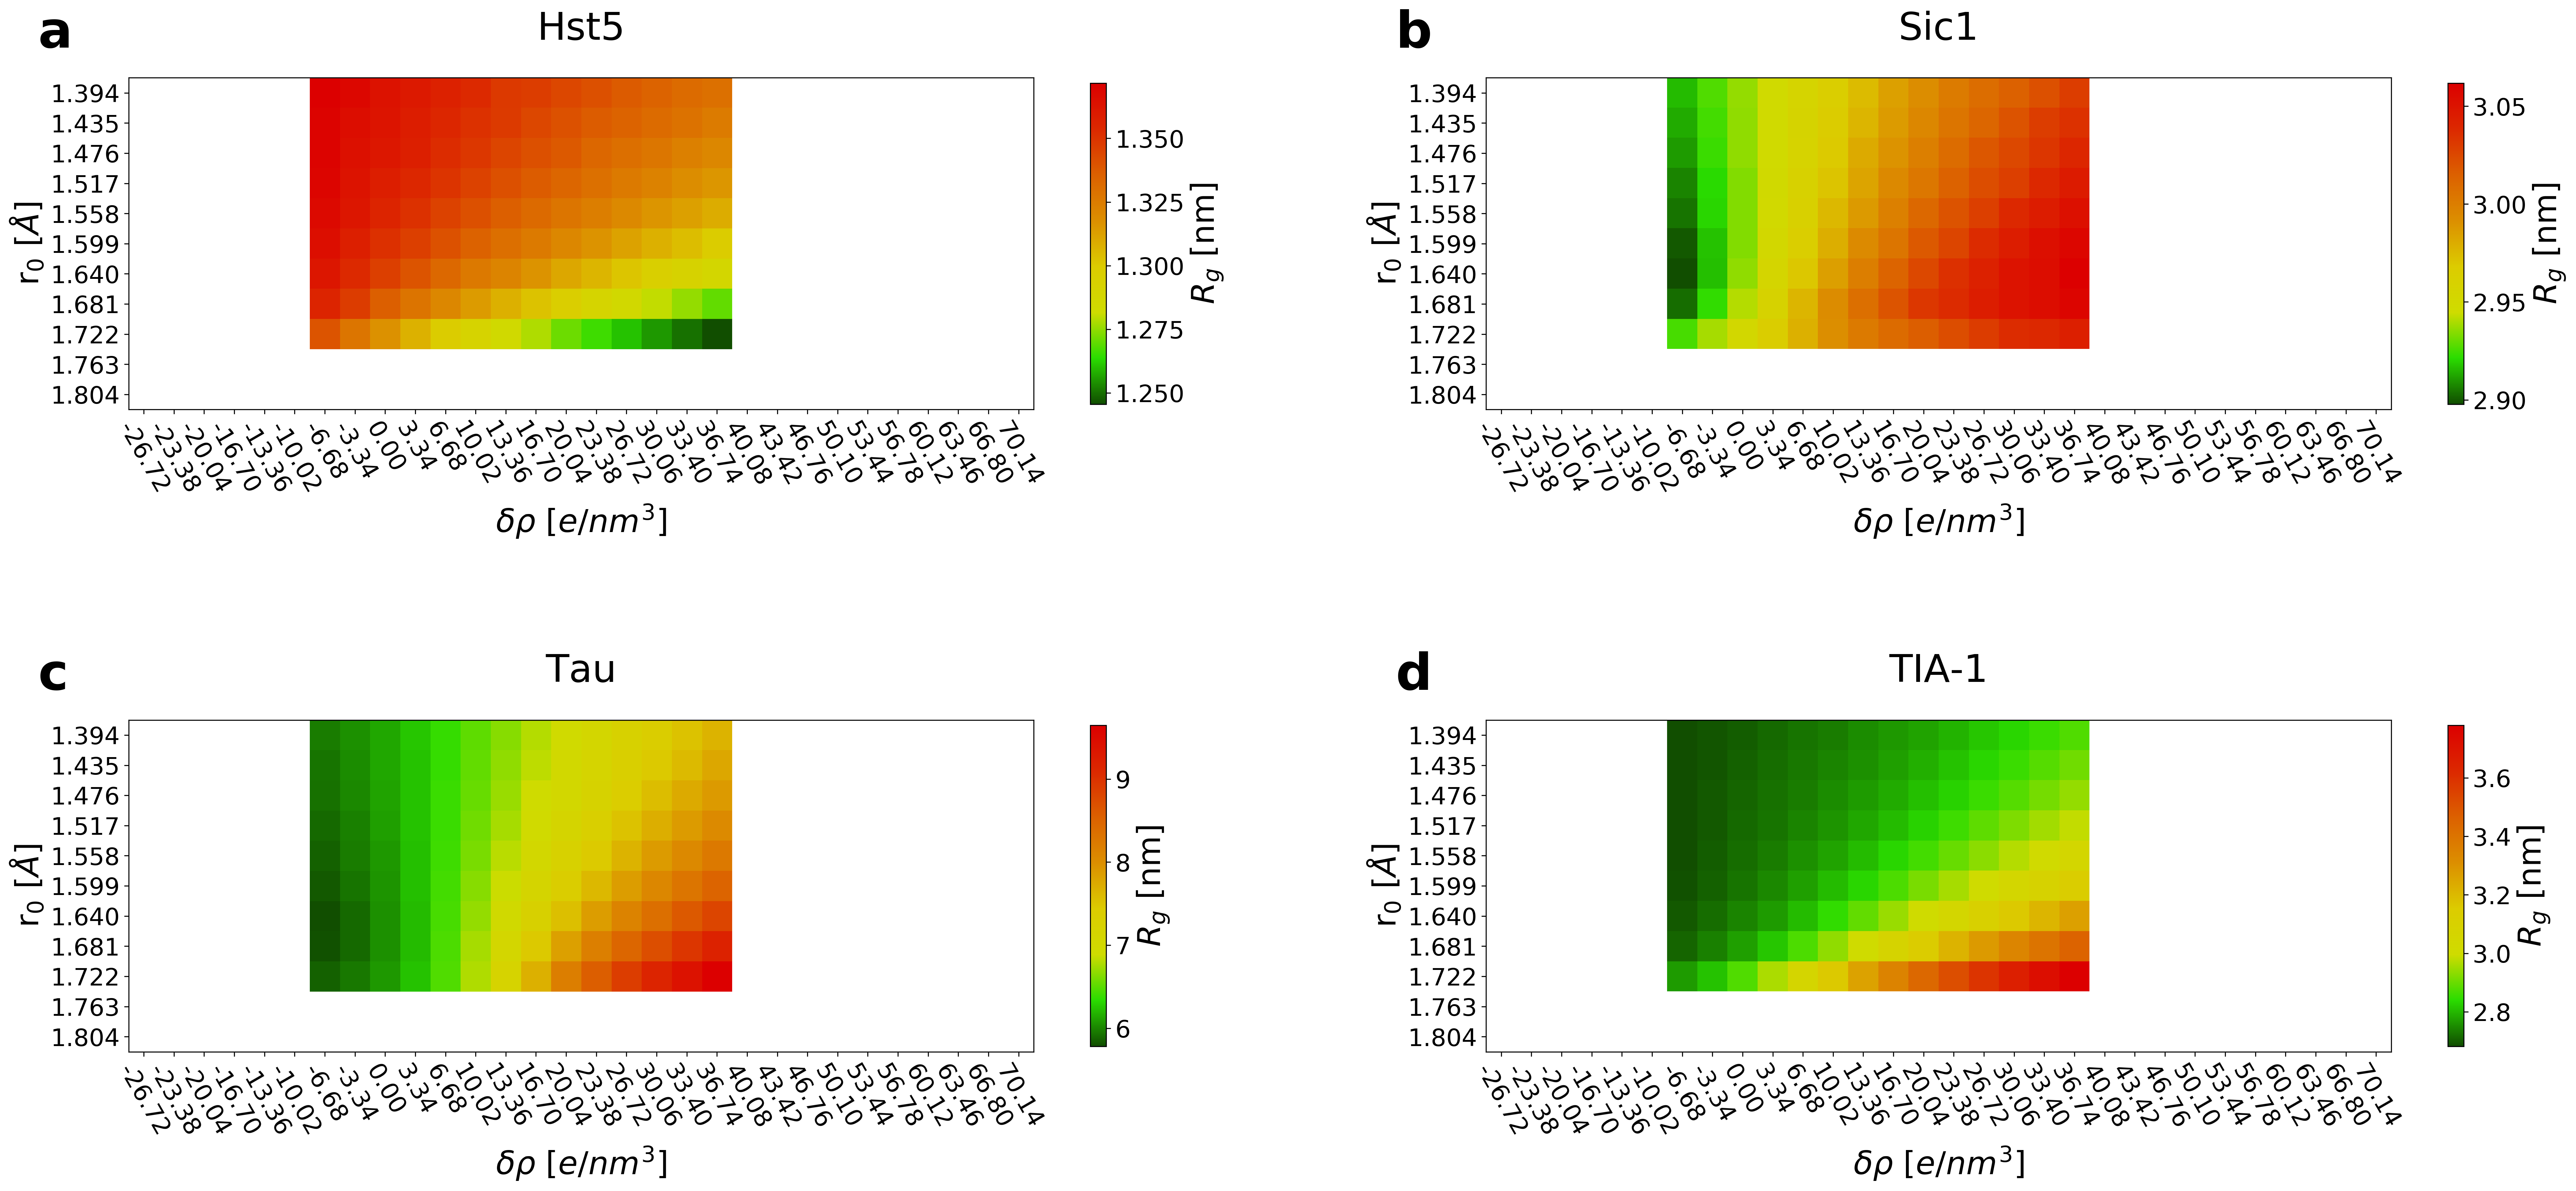

In [286]:
# Plotting central part of the grid (reasonable scores) with weighted average Rgs
mpl.rcParams['font.size'] = 19
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(35,17), facecolor='w', dpi=300)
c=0
for i in range(2):
    for j in range(2):
        p = tuple(grids.keys())[c]
        axs[i,j].set_title(p,pad=30, fontsize=30)
        a = np.array(rg_avs[p]).reshape(len(dro),len(r0)).T
        a[9:,:] = np.inf
        a[:,0:6] =np.inf
        a[:,20:30] =np.inf
        im = axs[i,j].imshow(a, cmap=rtg)
        axs[i,j].set_yticks(np.arange(len(r0)))
        axs[i,j].set_yticklabels(('%.3f'%(x) for x in r0))
        axs[i,j].set_xticks(np.arange(len(dro)))
        axs[i,j].set_xticklabels(('%.2f'%(x) for x in dro), Rotation=300)
        axs[i,j].set_xlabel(r'$\delta\rho$ $[e/nm^3]$', fontsize=25)
        axs[i,j].set_ylabel(r'r$_0$ $[\AA]$', fontsize=25)
        axs[i,j].text(-3.5,-1.5, string.ascii_lowercase[c], fontsize=40, weight='bold')
        plt.colorbar(im, ax=axs[i,j],shrink=0.60).set_label(r'$R_g$ [nm]', fontsize=25)
        c += 1
plt.savefig('rg_grid.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

/lindorffgrp-isilon/francesco/PROJECTS/HYDRA/hydratool.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([x,kde,av])
/lindorffgrp-isilon/francesco/PROJECTS/HYDRA/hydratool.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([x,kde,av])
/lindorffgrp-isilon/francesco/PROJECTS/HYDRA/hydratool.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

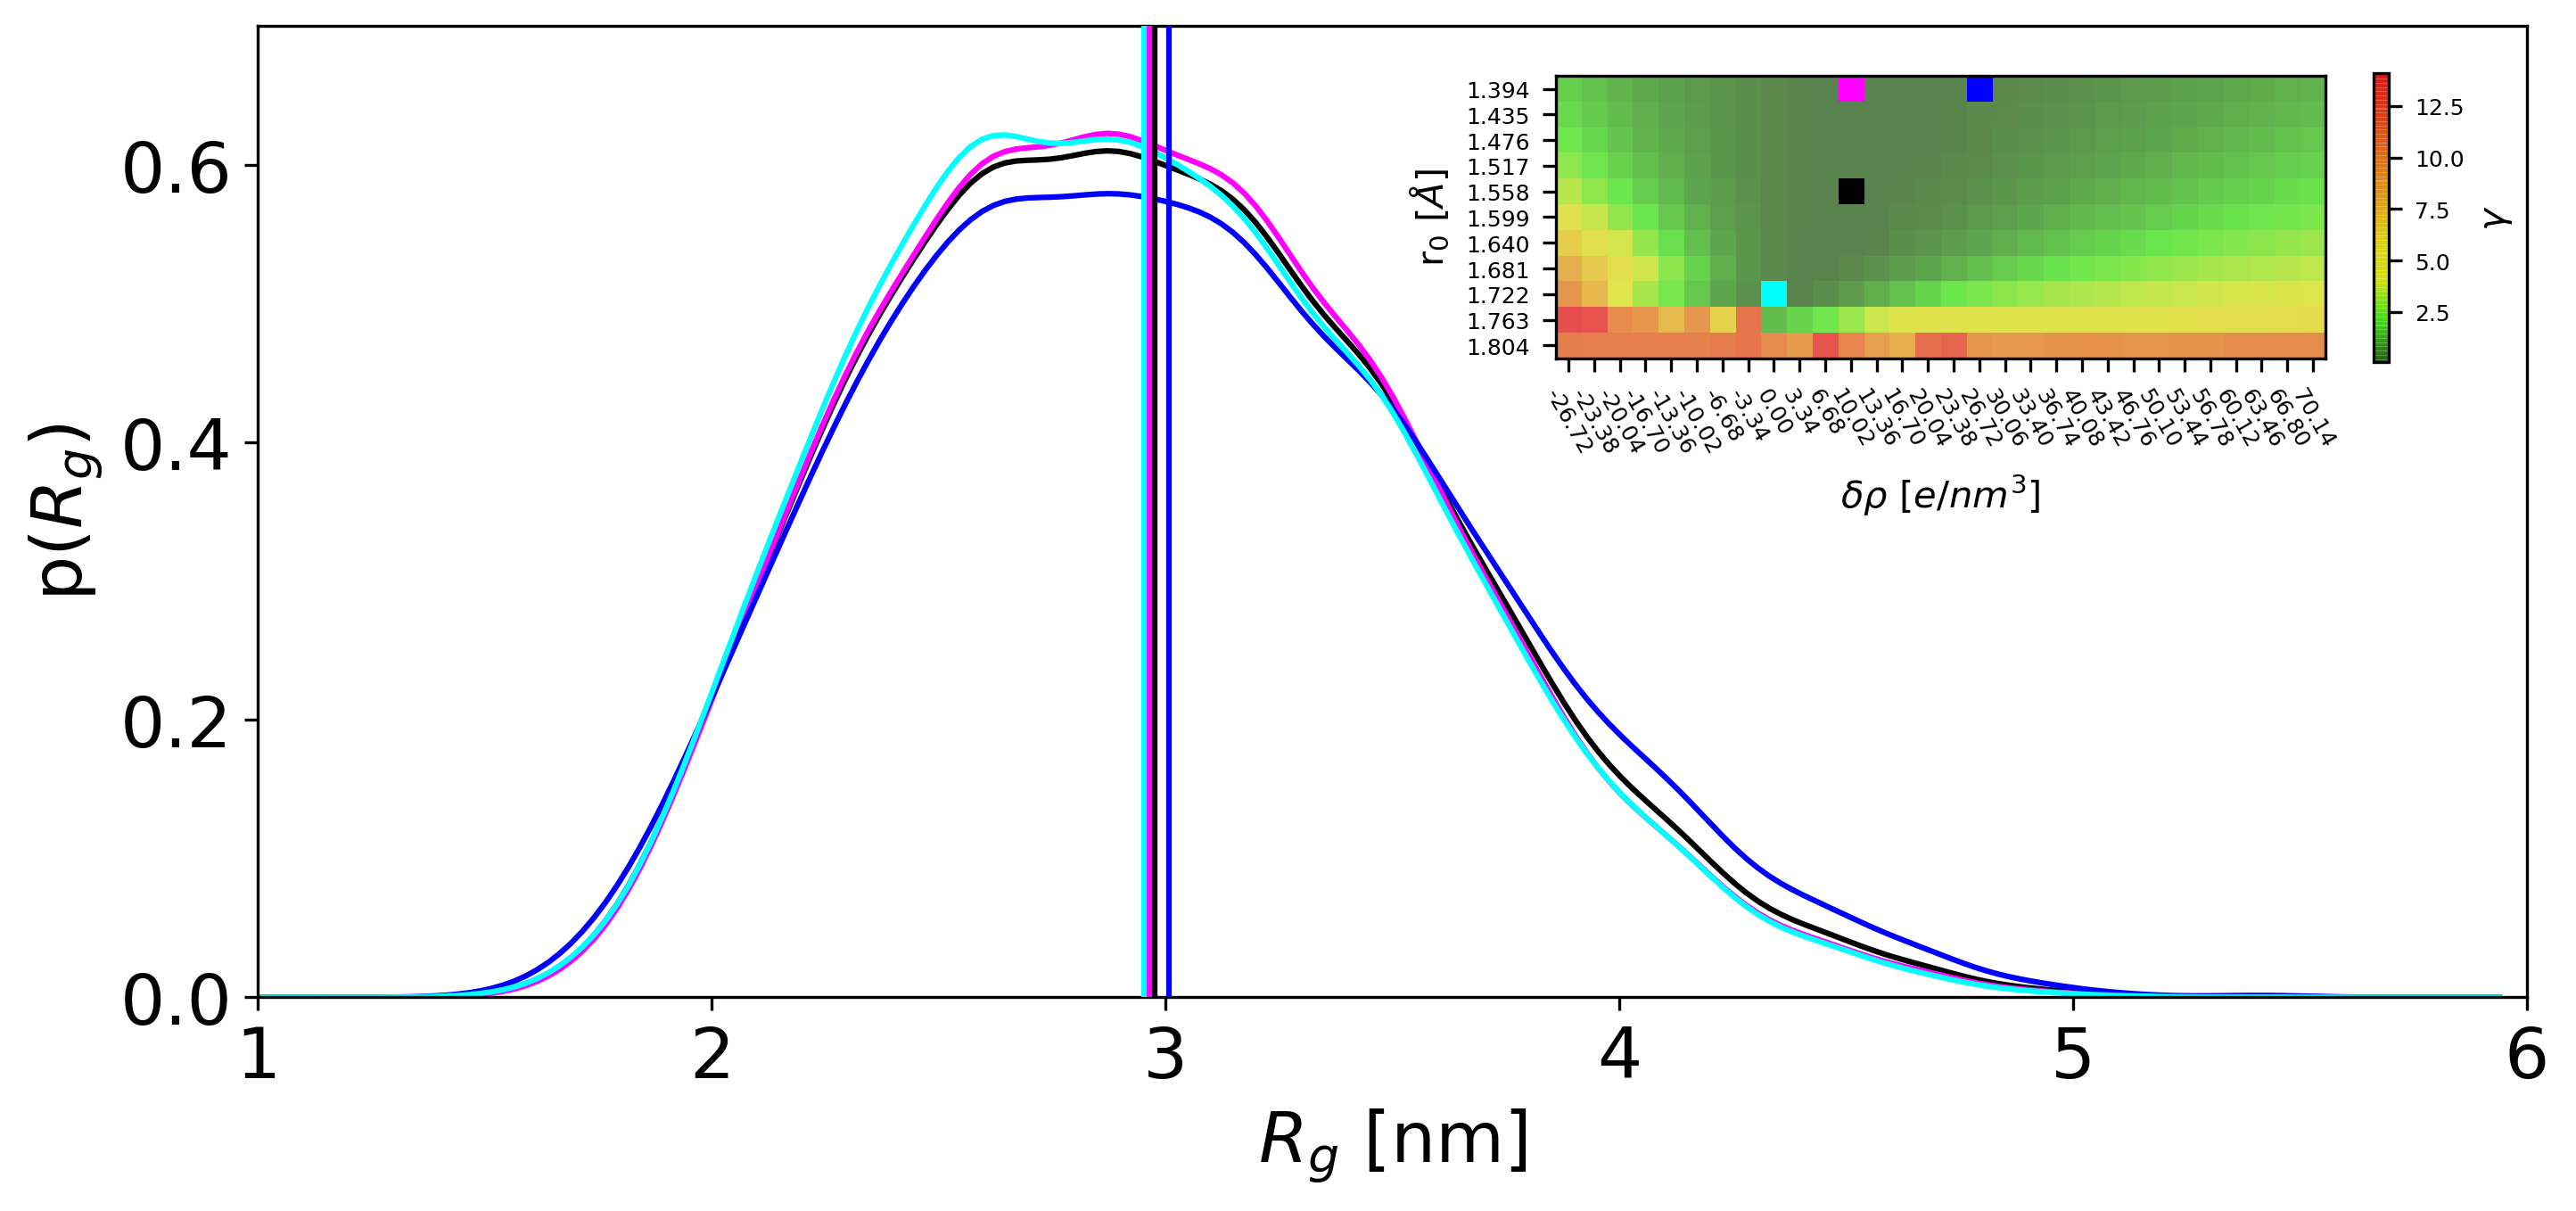

In [308]:
# Comparing reweighted Rg distributions and averages in spots of the Sic1 grid with optimal and suboptimal scores
mpl.rcParams['font.size'] = 19
fig, axs = plt.subplots(figsize=(10,5), facecolor='w', dpi=300)
newax = fig.add_axes([0.6, 0.6, 0.36, 0.36], anchor='NE', zorder=100)
im = newax.imshow(grids['Sic1'][...,6].reshape(len(dro),len(r0)).T, cmap=rtg,alpha=0.7)

for c,i in zip(['k','magenta','blue','cyan'],(125,121,176,96)):
    rg_tmp = rg_kde(rg['Sic1'], w = np.loadtxt(dirs['Sic1']+'WEIGHTS/w'+str(i)+'.dat')[...,1])
    axs.plot(rg_tmp[0],rg_tmp[1],label=i,c=c)
    
    axs.vlines(rg_tmp[2],0,0.9,color=c,zorder=300)
    
    mask = np.full(np.shape(klds['Sic1']),np.inf)
    mask[i] = 100
    new_cmap = [c,c]
    cmap_tmp = LinearSegmentedColormap.from_list("rtg", new_cmap)
    newax.imshow(mask.reshape(len(dro),len(r0)).T, cmap=cmap_tmp)
        
newax.axis('on')
newax.set_yticks(np.arange(len(r0)))
newax.set_yticklabels(('%.3f'%(x) for x in r0),fontsize=6)
newax.set_xticks(np.arange(len(dro)))
newax.set_xticklabels(('%.2f'%(x) for x in dro), Rotation=300, fontsize=6)
newax.set_xlabel(r'$\delta\rho$ $[e/nm^3]$', fontsize=10)
newax.set_ylabel(r'r$_0$ $[\AA]$', fontsize=10)
cb = plt.colorbar(im, ax=newax,shrink=0.60)
cb.set_label(r'$\gamma$', fontsize=10)
cb.ax.tick_params(labelsize=6)

axs.set_ylabel(r'p($R_g$)')
axs.set_xlabel(r'$R_g$ [nm]')
axs.set_ylim(0,0.7)
axs.set_xlim(1,6)

plt.tight_layout()
plt.savefig('rg.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
#plt.title('Sic1')
plt.show()

In [5]:
# Guinier approximation on the experimental profiles variating the q-range
c = 0
guiniers = {}
cut = [10,0,0,0]
start = [125,8,25,10]
end = [350,100,200,100]
for k in grids.keys():
    guiniers[k] = guinier_scan(exps[k],cut[c],start[c],end[c])
    c = c+1

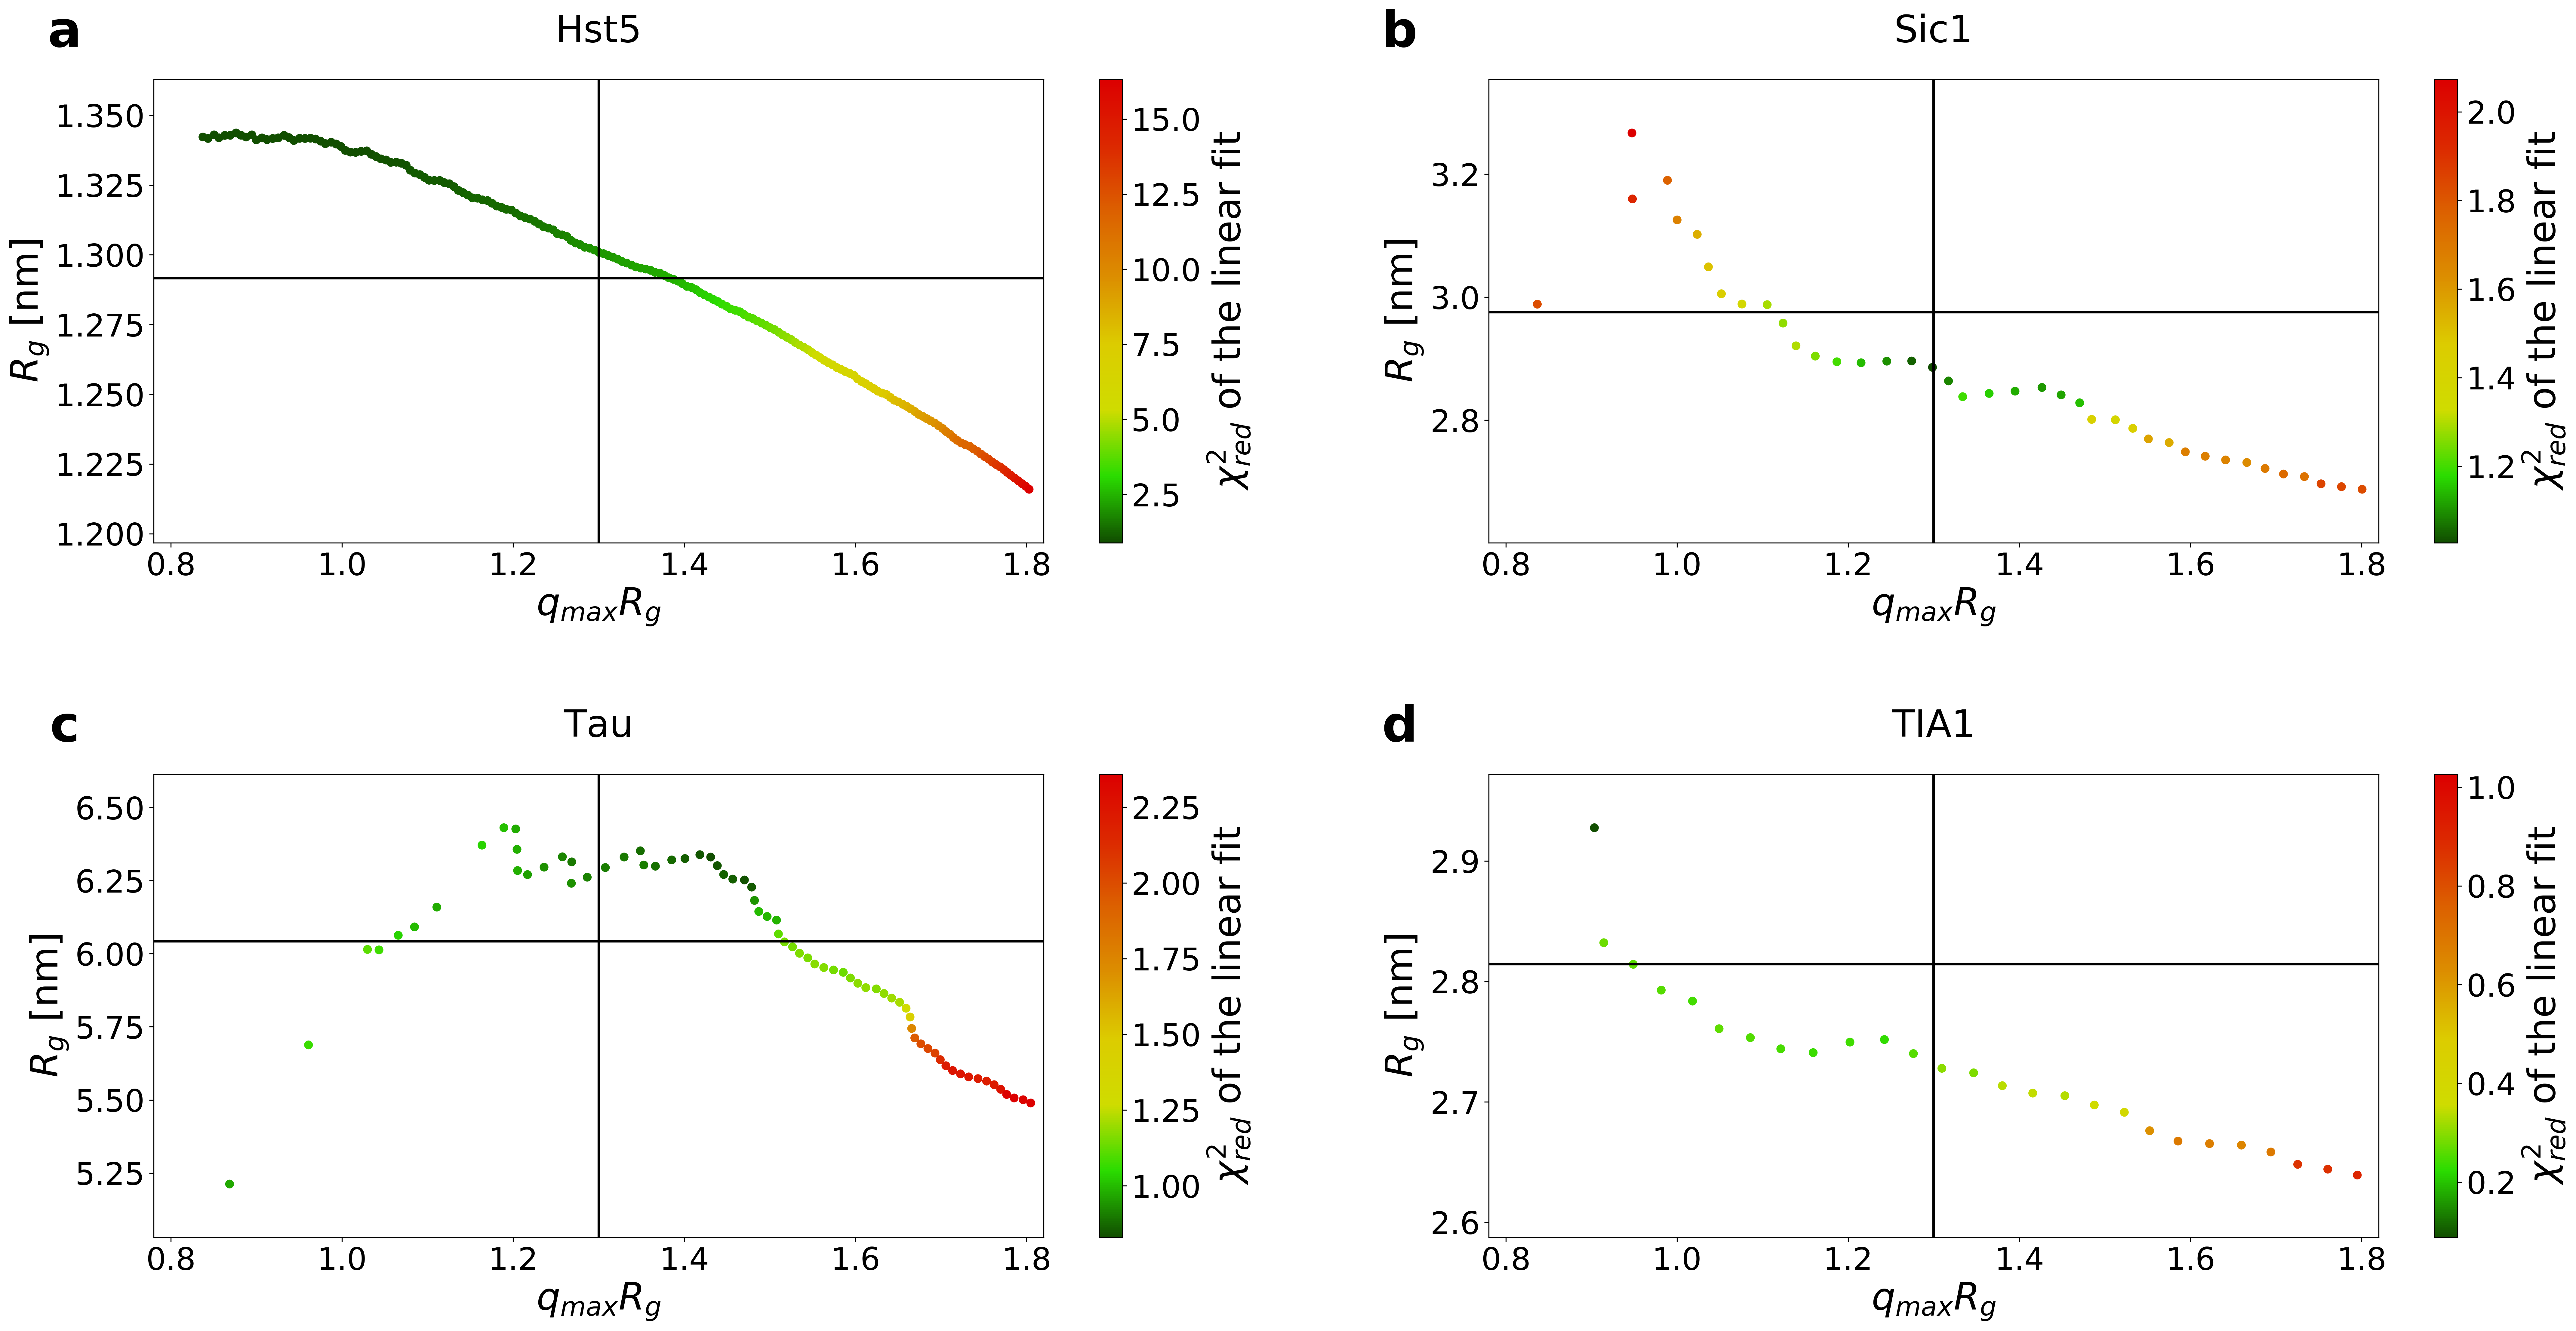

In [18]:
c=0
mpl.rcParams['font.size'] = 25
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(35,17), facecolor='w', dpi=300, gridspec_kw={'hspace': 0.5})
for i in range(2):
    for j in range(2):
        p = tuple(guiniers.keys())[c]
        
        axs[i,j].set_title(p,pad=30, fontsize=30)
        im = axs[i,j].scatter(guiniers[p][0],guiniers[p][1],c=guiniers[p][2], cmap=rtg)
        axs[i,j].set_xlim(0.8,1.85)
        axs[i,j].set_xlabel(r'$q_{max}R_{g}$', fontsize=30)
        axs[i,j].set_ylabel(r'$R_{g}$ [nm]', fontsize=30)
        axs[i,j].text(-0.1,1.1, string.ascii_lowercase[c], fontsize=40, weight='bold',horizontalalignment='center', verticalalignment='center',transform=axs[i,j].transAxes)
        plt.colorbar(im, ax=axs[i,j],shrink=1.).set_label(r'$\chi^2_{red}$ of the linear fit', fontsize=30)
        
        min_ = np.min(guiniers[p][1])
        max_ = np.max(guiniers[p][1])
        diff = max_ - min_
        vmin = min_ - 0.15*diff
        vmax = max_ + 0.15*diff
        axs[i,j].vlines(1.3,vmin,vmax,linewidth=2)
        axs[i,j].set_ylim(vmin,vmax)
        
        rg_tmp = rg_kde(rg[p], w = np.loadtxt(p+'_WEIGHTS/w'+str(mins[p][0])+'.dat')[...,1])
        axs[i,j].hlines(rg_tmp[2], 0.78, 1.82, linewidth=2)
        axs[i,j].set_xlim(0.78,1.82)

        c += 1

plt.savefig('guinier.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()